# Module 5: Classification

* So far, we have focused on _regression_ tasks where the objective is to predict a scalar continuous value, given some inputs
* In many tasks however, the output is neither continuous nor ordered, e.g., predict whether an image is a cat, dog, or lion. 
* Such tasks are called _classification_ tasks because the objective is to classify the input into one of $N$ classes

# Binary Classification

## Linearly Separable Example

* Consider the figure below. We have two kinds of points: <font color="orange">orange</font> and <font color="blue">blue</font>. They are described by two features, $x_1$ and $x_2$ and distributed as shown in the figure. 

![alt text](figures/simple_binary_classification.png)

* We want a rule that takes a point $p = (x_1, x_2)$ and tells us whether it is orange or blue. 
* A simple rule would be a line: if the point is above the line, predict it to be blue, and if it is below the line, predict it to be orange.
* Ok, so which line should we pick?

![alt text](figures/simple_binary_classification_lines.png)

* Different lines yield different classification accuracies
* The line on the far right is the best as it perfectly classifies all instances

## Nonseparable Example

* Consider the Figure below, can you find a line that separates the orange and blue points?

![alt text](figures/nonseparable_binary_classification.png)

* Here are a few example lines:

![alt text](figures/nonseparable_binary_classification_lines.png)

* We cannot separate the points with just a line
* We'll use a neural net to solve this problem

## Binary Cross-Entropy Loss

* But what should the objective of the neural network be in this case? 
* Mean squared error is inappropriate as there is no notion of distance between predicting orange vs. blue
* We can use accuracy (how many predictions are correct) but that is not a differentiable function
* Recall that a neural network cannot output discrete values, such as 0, 1, 2, etc. It only works with continuous activations.
* Suppose instead that the network outputs the _probability_ that a point is orange. In this case, the standard way is to use an objective or loss function called _cross entropy_:

$$\mathcal{L}(\pi_{i},y_{i})=-(y_{i}log(\pi_{i})+(1-y_{i})log(1-\pi_{i}))$$

* Where $\pi_i$ is the network's output (probability that a point is orange), and $y_i$ is the actual class label: 0 for blue, and 1 for orange.
* Let's plot the function to see how it behaves as the neural network output changes:


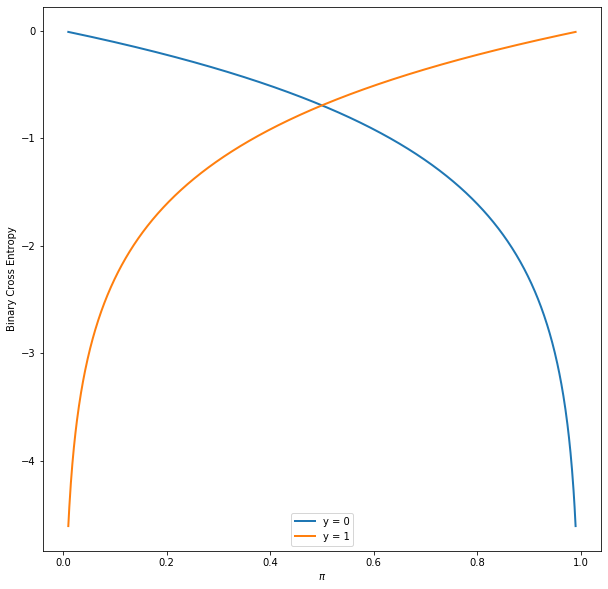

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 


# preds
probs = np.linspace(1e-2, 0.99, 1000)


f, ax = plt.subplots(1, 1, figsize=(10, 10))


# actual class label
actual_label = 0.0
# loss
xe = actual_label * np.log(probs) + (1-actual_label) * np.log(1-probs)

ax.plot(probs, xe, linewidth=2, label='y = 0')

actual_label = 1.0
xe = actual_label * np.log(probs) + (1-actual_label) * np.log(1-probs)
ax.plot(probs, xe, linewidth=2, label='y = 1')
ax.set_xlabel(r'$\pi$')
ax.set_ylabel(r'Binary Cross Entropy')
ax.legend()

* When the actual class label is $1$ (an orange point), the loss approaches $0$ as the probability of an orange point approaches $1$.
* Conversely, when the actual class label is $0$ (a blue point), the loss approaches $0$ as the probability of an orange point approaches $0$.
* The loss heavily penalizes the model if it assigns too low a probability for an orange point, or too high a probability for a blue point.
* What we've just seen is the loss for a single point, what about for a whole collection of points? it is just the average:

$$\mathcal{L}(\boldsymbol{\pi},\boldsymbol{y})=\frac{1}{N}\sum_{i}\mathcal{L}(\pi_{i},y_{i})$$

## Neural Network Implementation

* Armed with a differentiable loss and continuous output, we can implement a neural network model that predicts the color of a point


In [38]:
import numpy.random as rng 
import tensorflow as tf
import sklearn.metrics

# try varying the number of hidden units
n_hidden = 10
eta = 1.0

# read data
data = np.load('data/binary_classification.npz')
X, y = data['X'], data['y']

# move data to tensorflow space
X = tf.convert_to_tensor(X, dtype=tf.float32)
y = tf.convert_to_tensor(y, dtype=tf.float32)

# randomly initialize model parameters
W_input_hidden = tf.Variable(rng.randn(X.shape[1], n_hidden), dtype=tf.float32) 
W_hidden_output = tf.Variable(rng.randn(n_hidden, 1), dtype=tf.float32)
b_hidden = tf.Variable(rng.randn(n_hidden), dtype=tf.float32)
b_output = tf.Variable(rng.randn(1), dtype=tf.float32)
variables = [W_input_hidden, W_hidden_output, b_hidden, b_output]

# create optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=eta)

# repeat N times
N = 100
for i in range(N):
    
    with tf.GradientTape() as gt:
        
        # forward computation
        hidden_activation = tf.tanh(b_hidden + tf.matmul(X, W_input_hidden))
        pi = tf.sigmoid(b_output + tf.matmul(hidden_activation, W_hidden_output))
       
        # loss
        xe_loss = -tf.reduce_mean( y * tf.math.log(pi) + (1-y) * tf.math.log(1-pi) )
        
        #print("LOSS: %0.4f" % (xe_loss.numpy()))
    # compute gradient of loss with respect to parameters
    # calculus NOT required!
    gradients = gt.gradient(xe_loss, variables)
    
    # update the parameters
    # this takes a list where each element is a tuple
    # of (gradient, corresponding parameter)
    optimizer.apply_gradients(zip(gradients, variables))

# report results
hidden_activation = tf.tanh(b_hidden + tf.matmul(X, W_input_hidden))
pi = tf.sigmoid(b_output + tf.matmul(hidden_activation, W_hidden_output))
xe_loss = -tf.reduce_mean( y * tf.math.log(pi) + (1-y) * tf.math.log(1-pi) )
print("Final XE: %0.4f" % xe_loss.numpy())

# report results
pi = pi.numpy()
pred_1 = pi > 0.5
acc = np.mean(y.numpy() == pred_1)
print("Accuracy: %0.2f" % acc)

Final XE: 0.2463
Accuracy: 0.90


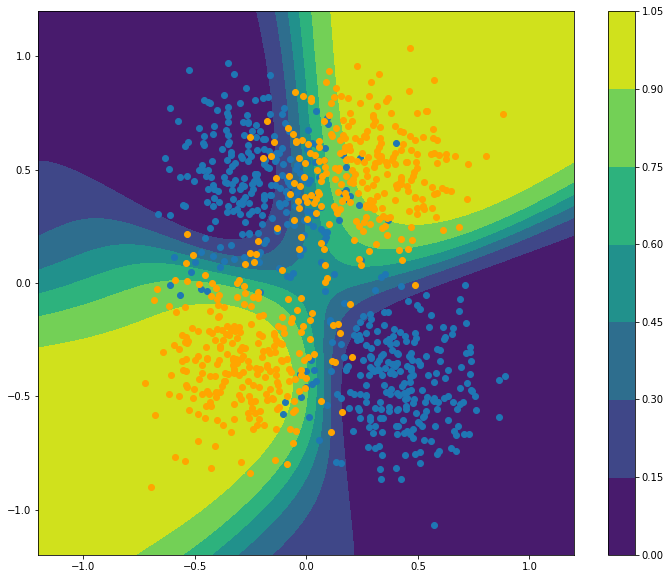

In [36]:
# let's see what the network has learned

# initialize range of input values
K = 100
xs = np.linspace(-1.2, 1.2, K)
x1s, x2s = np.meshgrid(xs, xs)

# zip the inputs up into a (K*K, 2) array
Xstar = np.vstack((x1s.flatten(), x2s.flatten())).T
Xstar = tf.convert_to_tensor(Xstar, dtype=tf.float32)

# predict
hidden_activation = tf.tanh(b_hidden + tf.matmul(Xstar, W_input_hidden))
pi_star = tf.sigmoid(b_output + tf.matmul(hidden_activation, W_hidden_output))

# plot
pi_star = pi_star.numpy().reshape((K, K))

f, ax = plt.subplots(1, 1, figsize=(12, 10))
cp = ax.contourf(x1s, x2s, pi_star)

# read data
data = np.load('data/binary_classification.npz')
X, y = data['X'], data['y']

class0_ix = y[:,0] == 0
class1_ix = y[:,0]== 1

ax.scatter(X[class0_ix, 0], X[class0_ix, 1])
ax.scatter(X[class1_ix, 0], X[class1_ix, 1], color='orange')
f.colorbar(cp)

* The model has learned a non linear function that correctly maps out the regions of the two classes.

## Binary Classifiers Performance Evaluation

* As you may have noticed, we convert classifier output probability into a hard (orange or blue) decision by outputing orange if the probability is above 0.5

* However, this choice of 0.5 is arbitary; the classifier could output probabilities in the range of 0.3-0.4 for example and so applying this rule would make the classifier predict blue all the time.

* Let's compute accuracy at different thresholds for the following simple example:


In [22]:
y_actual = [0, 1, 1, 0, 1, 1, 0]
y_pred = [0.06, 0.92, 0.86, 0.03, 0.40, 0.70, 0.23]

for thres in np.linspace(0, 1, 9):
    hard_pred = y_pred > thres
    acc = np.mean(hard_pred == y_actual)
    print("Accuracy at %0.2f: %0.2f" % (thres, acc))
        

Accuracy at 0.00: 0.57
Accuracy at 0.12: 0.86
Accuracy at 0.25: 1.00
Accuracy at 0.38: 1.00
Accuracy at 0.50: 0.86
Accuracy at 0.62: 0.86
Accuracy at 0.75: 0.71
Accuracy at 0.88: 0.57
Accuracy at 1.00: 0.43


* The accuracy when the threshold is 0.25 or 0.38 is highest
* We want a metric that characterizes classifier performance at different thresholds
* The standard metric for this is called the Area-Under-the-Receiver-Operating-Characteristic-Curve (AUC-ROC).
* AUC-ROC is the probability that a classifier ranks a positive instance higher than a negative one. That is, it is the probability that a positive instance receives a higher $\pi_i$ value than a negative one.
* AUC-ROC ranges from 0.5 to 1.0, with 0.5 indicating a classifier no better than random coin toss, and 1.0 indicating a perfect classifier.
* The ROC curve is computed by sweeping the thresholds and computing the false negative rate (FNR) and the true positive rate (TPR). 
    * TPR is the proportion of positive instances that the classifier correctly identified $TPR = TP / (TP + FN)$, where $TP$ means true positive, $FN$ means false negative.
    * FNR is the proportion of positive instances that the classifier incorrectly identified as negative $FNR = 1 - TPR$.
* AUC-ROC is then simply the area under the ROC curve.

AUC-ROC: 0.92


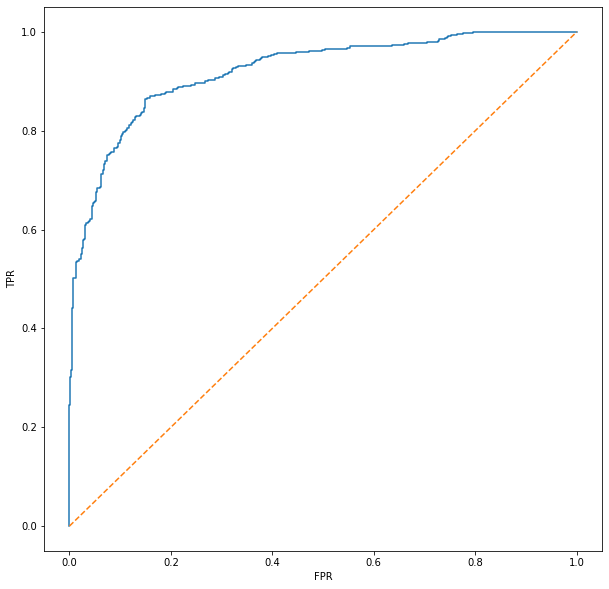

In [32]:
fpr, tpr,_ = sklearn.metrics.roc_curve(y, pi)

f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(fpr, tpr)
ax.plot(fpr, fpr, linestyle='dashed')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
auc_roc = sklearn.metrics.roc_auc_score(y, pi)
print("AUC-ROC: %0.2f" % auc_roc)

# Multiclass Classification

* The natural extension to binary classification is multiclass classification, where the model has to predict the probability of more than two classes. For example,

![alt text](figures/multiclass_classification.png)

* Before we implement this with a neural network, we need to take care of three things: representing the classes, the output of the neural network, and the loss function.

## Class Representation: One-hot Encoding

* Let's load the dataset representing the previous figure and examine how the outputs are coded:

In [4]:
d = np.load('data/multiclass_classification.npz')
X, y = d['X'], d['y']
print(y[:5]) # print classes of first five points

[[3]
 [0]
 [5]
 [2]
 [1]]


* So the classes are represented with a number from 0 to 5 (6 classes)
* But remember: classes have no ordering relationship, class 1 is not "less" than class 5. So we cannot train the network on the dataset as it is
* We need a way to tell the network that classes are not ordered. This is done via _one-hot encoding_: create a binary vector with $N$ entries, and set the bit that corresponds to the class, for example:

In [5]:
n_classes = 5

theclass = 3
one_hot_encoded = np.zeros(n_classes)
one_hot_encoded[theclass] = 1
print(one_hot_encoded)

theclass = 0
one_hot_encoded = np.zeros(n_classes)
one_hot_encoded[theclass] = 1
print(one_hot_encoded)

[0. 0. 0. 1. 0.]
[1. 0. 0. 0. 0.]


* And here is how to convert the outputs in the datset into one-hot encoded values:

In [6]:
# get number of classes in the dataset
n_classes = np.max(y) + 1

# allocate storage
Y = np.zeros((y.shape[0], n_classes))

# set bits
Y[np.arange(y.shape[0]), y[:,0]] = 1

# print first few entries
print(Y[:5,:])

[[0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]


## Network Output: Softmax

* Great, now the each output is a binary vector, with one bit set and the rest are zeros
* As with binary classification. The network should output the _probability_ of each class. But how to do this?
* Remember: the probabilities of mutually exclusive events should sum to one (a point cannot be in class 0 and 3 simultanously)
* Also remember: each probability should be between 0.0 and 1.0

First, consider the $\text{argmax}$ function, which takes a vector of numbers and returns a corresponding bit vector with one set in the position of the maximum element in the input vector.


In [7]:
# sample input vector
z = [1, 2, 3, 0, -1]
ix = np.argmax(z)
r = np.zeros(len(z))
r[ix] = 1
print(r)

[0. 0. 1. 0. 0.]


* Neural networks cannot implement such function because it is not differentiable

* Instead, we use a softer version, called _softmax_:

$$\text{softmax}(z_{1},...,z_{n})=\left[\frac{e^{z_{1}}}{\sum e^{z_{i}}},...,\frac{e^{z_{n}}}{\sum e^{z_{i}}}\right]$$

* Here, $z_i$ is a continuous real number that can be negative, positive or zero. 
* Softmax takes a vector of such numbers and outputs a corresponding vector that (a) sums to 1.0 and (b) where each element is between 0 and 1.

In [8]:
z = [1, 2, 3, 0, -1]
smax = np.exp(z) / np.sum(np.exp(z))
with np.printoptions(precision=3, suppress=True):
    print(smax)
print(np.sum(smax))

[0.086 0.234 0.636 0.032 0.012]
1.0


* Notice how the greatest element gets assigned the highest probability and that the sum of elements is 1.0

## Loss Function: Categorical Cross Entropy

* The final piece of the puzzle is the loss function used to train the network
* For multiclass classification, the loss is the generalization of binary cross entropy:

$$\mathcal{L}(\boldsymbol{\pi}_{i},\boldsymbol{y}_{i})=-\sum_{j}y_{i}^{j}log(\pi_{i}^{j})$$

* Here, $\boldsymbol{\pi}_{i}$ is a vector of class probabilities (output of softmax) and $\boldsymbol{y}_{i}$ is the one-hot encoded class label.

* The model gets rewarded when it assigns a high probability to the true class.

* You can check that this loss reduces to binary cross entropy when there are two classes.

## Neural Network Implementation

* Time to put things together and implement a classifier that predicts the classes of points in the dataset.

In [15]:
# try varying the number of hidden units
n_hidden = 10
eta = 1.0

# read data
data = np.load('data/multiclass_classification.npz')
X, y = data['X'], data['y']

# convert to one-hot-encoding
n_classes = np.max(y) + 1
Y = np.zeros((y.shape[0], n_classes))
Y[np.arange(y.shape[0]), y[:,0]] = 1

# move data to tensorflow space
X = tf.convert_to_tensor(X, dtype=tf.float32)
Y = tf.convert_to_tensor(Y, dtype=tf.float32)

# randomly initialize model parameters
# notice how we now output n_classes instead of one output
W_input_hidden = tf.Variable(rng.randn(X.shape[1], n_hidden), dtype=tf.float32) 
W_hidden_output = tf.Variable(rng.randn(n_hidden, n_classes), dtype=tf.float32)
b_hidden = tf.Variable(rng.randn(n_hidden), dtype=tf.float32)
b_output = tf.Variable(rng.randn(n_classes), dtype=tf.float32)
variables = [W_input_hidden, W_hidden_output, b_hidden, b_output]

# create optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=eta)

# repeat N times
N = 100
for i in range(N):
    
    with tf.GradientTape() as gt:
        
        # forward computation
        hidden_activation = tf.tanh(b_hidden + tf.matmul(X, W_input_hidden))
        pi = tf.nn.softmax(b_output + tf.matmul(hidden_activation, W_hidden_output))
        
        # pi has shape (# data points, n_classes)
        
        # loss
        xe_loss = -tf.reduce_mean( tf.reduce_sum(Y * tf.math.log(pi), axis=1) )
        
        #print("LOSS: %0.4f" % (xe_loss.numpy()))
    # compute gradient of loss with respect to parameters
    # calculus NOT required!
    gradients = gt.gradient(xe_loss, variables)
    
    # update the parameters
    # this takes a list where each element is a tuple
    # of (gradient, corresponding parameter)
    optimizer.apply_gradients(zip(gradients, variables))

# report results
hidden_activation = tf.tanh(b_hidden + tf.matmul(X, W_input_hidden))
pi = tf.nn.softmax(b_output + tf.matmul(hidden_activation, W_hidden_output))

# report results
pi = pi.numpy()
class_preds = np.argmax(pi, axis=1)
acc = np.mean(class_preds == y[:,0])
print("Accuracy: %0.2f" % acc)
train_pi = pi

Accuracy: 0.90


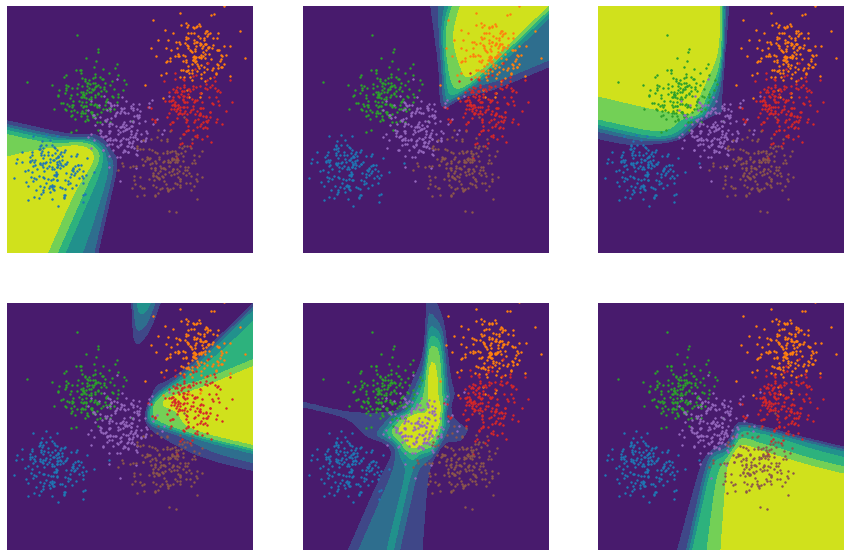

In [20]:
# let's see what the network has learned

# initialize range of input values
K = 100
xs = np.linspace(-15, 15, K)
x1s, x2s = np.meshgrid(xs, xs)

# zip the inputs up into a (K*K, 2) array
Xstar = np.vstack((x1s.flatten(), x2s.flatten())).T
Xstar = tf.convert_to_tensor(Xstar, dtype=tf.float32)

# predict
hidden_activation = tf.tanh(b_hidden + tf.matmul(Xstar, W_input_hidden))
pi = tf.nn.softmax(b_output + tf.matmul(hidden_activation, W_hidden_output))

f, axes = plt.subplots(2, int(n_classes/2), figsize=(15, 10), sharex=True, sharey=True)

axes = axes.flatten()

data = np.load('data/multiclass_classification.npz')
X, y = data['X'], data['y']

for i, ax in enumerate(axes):
    pi_class = pi[:, i]
    pi_class = np.reshape(pi_class, (K,K))
    cp = ax.contourf(x1s, x2s, pi_class)
    for j in range(n_classes):
        ix = y[:,0] == j
        ax.scatter(X[ix, 0], X[ix, 1], s=2)
    ax.set_xlim([-15, 15])
    ax.set_ylim([-15,15])
    ax.axis('off')
    

## Multiclass Performance Evaluation: Confusion Matrix

* Reporting accuracy is fine but we usually want to know which categories or classes the classifier gets confused about

* For this, we use the confusion matrix. Rows correspond to actual labels and columns correspond to predicted labels. An ideal classifier would have a confusion matrix with 0s in the off-diagonal entries. 

* Let's compute the confusion matrix from our previous classifier:

In [16]:
import sklearn.metrics

preds = np.argmax(train_pi, axis=1)
cm = sklearn.metrics.confusion_matrix(y, preds)
print(cm)

[[164   0   2   0   1   0]
 [  0 126   0  40   1   0]
 [  0   0 162   0   5   0]
 [  0   5   0 156   1   5]
 [  1   1  18   4 137   5]
 [  0   0   0   4   6 156]]


* The classifier correctly predicts 126 instances of class 1, but mispredicts 40 as class 3 and 1 as class 4.

* We can row-normalize the confusion matrix to get percentages. Row-normalization makes the entries in each row sum to 1.0

In [19]:
cm = cm / np.sum(cm, axis=1, keepdims=True)
with np.printoptions(precision=2, suppress=True):
    print(cm)

[[0.98 0.   0.01 0.   0.01 0.  ]
 [0.   0.75 0.   0.24 0.01 0.  ]
 [0.   0.   0.97 0.   0.03 0.  ]
 [0.   0.03 0.   0.93 0.01 0.03]
 [0.01 0.01 0.11 0.02 0.83 0.03]
 [0.   0.   0.   0.02 0.04 0.94]]
